<img src="assets/OFE-color-horizontal.png" width="300"> 

# OpenFE binding affinity predictions from OpenFold3 generated structures

## Introduction

This notebook offers a brief preview of some of the steps one would need to go through to calculate binding affinities using [OpenFE](https://docs.openfree.energy/en/latest/) with [OpenFold3](https://openfold-3.readthedocs.io/en/latest/) generated structures.

Notably, we will demonstrate how to generate a set of predictions, clean them up for use in molecular dynamics simulations, and then apply them to both relative binding free energy (RBFE) and absolute binding free energy (ABFE) methods.

<div class="alert alert-block alert-danger"> 
⚠️ <b>Important Note:</b>
    Please note that this notebook does not offer an exhaustive look into all everyone you may need to do when parsing OpenFold3 inputs into OpenFE. Where possible, we offer insights into some of the other hurdles you may face, but you are likely to encounter more in production settings.
</div>

## Overview

In this example notebook we demonstrate how to predict and run simulations for different ligands bound to tyrosine kinase 2 (TYK2). The dataset comes from the [Wang et al. JACS 2015 dataset](https://pubs.acs.org/doi/10.1021/ja512751q).

<center><img src="assets/tyk2.png" width="400"></center>


**The tutorial is broken into the following steps:**

1. Run cofolding with OpenFold3 on a set of TYK2 ligands

2. Processing the OpenFold3 output for use with OpenFE

  - Choosing a reference protein structure
  - Aligning & extracting the ncessary ligands & protein structures.
  - Fixing & protonating the reference protein structure.

3. Loading structures into OpenFE Components

4. Creating an Absolute Binding Free Energy Transformation

5. Creating a SepTop Relative Binding Free Energy Transformation

6. Creating a Hybrid Topology Relative Binding Free Energy Transformation

## 1. Run cofolding with OpenFold3 on a set of TYK2 ligands

### Preparing the Input JSON for OpenFold

First we need to create an input JSON file for OpenFold. This step requires assembling two key pieces of information:

- Ligand SMILES strings
- Protein sequence (extracted from the PDB file)

In this workflow, we begin with an SDF file containing the ligands.
We extract the SMILES representation for each ligand and store them in a dictionary alongside their ligand identifiers.

In [1]:
ligands_file = "assets/tyk2_ligands.sdf"
from rdkit.Chem.Descriptors3D import Asphericity
from rdkit import Chem

ligands_dict = {}
sppl = Chem.SDMolSupplier(ligands_file, removeHs=True)
for mol in sppl:
    smi = Chem.MolToSmiles(mol)
    name = mol.GetProp("_Name")
    ligands_dict[name] = smi

In [2]:
ligands_dict

{'lig_ejm_31': 'CC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1',
 'lig_ejm_42': 'CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1',
 'lig_ejm_43': 'CC(C)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1',
 'lig_ejm_46': 'O=C(Nc1ccnc(NC(=O)C2CC2)c1)c1c(Cl)cccc1Cl',
 'lig_ejm_47': 'O=C(Nc1ccnc(NC(=O)C2CCC2)c1)c1c(Cl)cccc1Cl',
 'lig_ejm_48': 'O=C(Nc1ccnc(NC(=O)C2CCCC2)c1)c1c(Cl)cccc1Cl',
 'lig_ejm_50': 'O=C(CO)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1',
 'lig_jmc_23': 'O=C(Nc1ccnc(NC(=O)[C@H]2C[C@H]2F)c1)c1c(Cl)cccc1Cl',
 'lig_jmc_27': 'O=C(Nc1ccnc(NC(=O)[C@H]2C[C@H]2Cl)c1)c1c(Cl)cccc1Cl',
 'lig_jmc_28': 'C[C@@H]1C[C@@H]1C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1'}

We then create the json file that will be the OpenFold input.

In [3]:
import json

# Protein sequence and chain ID
protein_info = {
    "molecule_type": "protein",
    "chain_ids": "A",
    "sequence": "MGSPASDPTVFHKRYLKKIRDLGEGHFGKVSLYCYDPTNDGTGEMVAVKALKADAGPQHRSGWKQEIDILRTLYHEHIIKYKGCCEDAGAASLQLVMEYVPLGSLRDYLPRHSIGLAQLLLFAQQICEGMAYLHAQHYIHRNLAARNVLLDNDRLVKIGDFGLAKAVPEGHEYYRVREDGDSPVFWYAPECLKEYKFYYASDVWSFGVTLYELLTHCDSSQSPPTKFLELIGIAQGQMTVLRLTELLERGERLPRPDKCPAEVYHLMKNCWETEASFRPTFENLIPILKTVHEKYRHHHHHH"
}

# Build the queries dictionary
queries = {}

for name, smiles in ligands_dict.items():
    queries[name] = {
        "chains": [
            protein_info,
            {
                "molecule_type": "ligand",
                "chain_ids": "Z",  
                "smiles": smiles
            }
        ]
    }

# Write to JSON
with open("queries.json", "w") as f:
    json.dump({"queries": queries}, f, indent=4)

### Running OpenFold

#### Defining the output settings

By default OpenFold3 outputs `.mmcif` files, but OpenFE requires `.pdb` files. We can ask OpenFold to generate this instead by defining it in the output settings.

To do this, create an `output_settings.yml` file to specify .pdb as the output file format:

```
output_writer_settings:
  # change output format to pdb (default: mmcif):
  structure_format: pdb
```

#### Running OpenFold

With all these inputs, you can now run OpenFold:

`run_openfold predict --query_json=queries.json --runner_yaml output_settings.yml`

## 2. Processing the OpenFold3 output for use with OpenFE

<div class="alert alert-block alert-warning"> 
⚠️ <b>Important Note:</b>
    Here we use the first model for each complex predicted by OpenFold3. In practice you would filter through all predicted models, possibly using pose busters (https://github.com/maabuu/posebusters) and some other scoring metrics to identify the most plausible inputs.
</div>

### Preparing & extracting the structures

Now that we have a set of predicted structures, we must extract the relevant information from the PDB files.
This means:

1. Choosing a reference protein structure which will be used for all binding affinity predictions

  - This is necessary for RBFE simulations, where a single structure must be kept constant throughout the transformations. Note that for ABFE simulations, this step can be avoided.
  - For the sake of this demonstration, we will be choosing the predicted structure that is bound to the ligand occupying the largest volume. The idea here being that hopefully the binding site of that structure can accomodate all the other ligands. We note that in practice this is not always true.

2. Aligning all the structures to the chosen structure

  - This is so that we can extract the ligands and use them with the chosen structure.

3. Extracting the ligands to SDF files and the chosen protein structure to a PDB file.

4. Fixing protonation & capping issues with the PDB file.


#### Choosing a reference protein structure

As mentioned above, we will select a reference protein structure for all simulations going forward. To do this, we naively select the structure bound to a ligand with the largest volume.

Here we load in all the structures into MDAnalysis, extract the ligands into RDKit molecules using their initial SMILES definitions as bond/formal charge templates, and then get the ligand with the largest volume using the `Asphericity` 3D descriptor.

In [4]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
from rdkit import Chem
from rdkit.Chem import AllChem
import pathlib
from rdkit.Chem.Descriptors3D import Asphericity

# gather all the complexes and align to a single structure which has the largest ligand by volume?
ligand_templates = {
    "lig_ejm_31": "CC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1",
    "lig_ejm_42": "CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1",
    "lig_ejm_43": "CC(C)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1",
    "lig_ejm_46": "O=C(Nc1ccnc(NC(=O)C2CC2)c1)c1c(Cl)cccc1Cl",
    "lig_ejm_47": "O=C(Nc1ccnc(NC(=O)C2CCC2)c1)c1c(Cl)cccc1Cl",
    "lig_ejm_48": "O=C(Nc1ccnc(NC(=O)C2CCCC2)c1)c1c(Cl)cccc1Cl",
    "lig_ejm_50": "O=C(CO)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1",
   "lig_jmc_23": "O=C(Nc1ccnc(NC(=O)[C@H]2C[C@H]2F)c1)c1c(Cl)cccc1Cl",
    "lig_jmc_27": "O=C(Nc1ccnc(NC(=O)[C@H]2C[C@H]2Cl)c1)c1c(Cl)cccc1Cl",
    "lig_jmc_28": "C[C@@H]1C[C@@H]1C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1"
}
output_root = pathlib.Path("assets/of3_output")
temp_dir = pathlib.Path("assets/of3_output/temp_ligands")
temp_dir.mkdir(exist_ok=True)
# load all the output pdbs and calculate ligand volumes
ligand_volumes = {}
for output_file in output_root.glob("*.pdb"):
        ligand_name = output_file.name.split('_seed')[0]
        print(f"Extracting ligand from {output_file}...")
        u = mda.Universe(str(output_file))
        ligand = u.select_atoms("resname LIG")
        # write the ligand to a temporary file
        ligand.write(str(temp_dir / f"{ligand_name}.pdb"))
        # now load back with rdkit
        rdkit_mol = Chem.MolFromPDBFile(str(temp_dir / f"{ligand_name}.pdb"), removeHs=True)
        # now use a template to make sure the bond orders are correct
        template_mol = Chem.MolFromSmiles(ligand_templates[ligand_name])
        rdkit_mol = AllChem.AssignBondOrdersFromTemplate(template_mol, rdkit_mol)
        # calculate the volume
        vsa = Asphericity(rdkit_mol)
        ligand_volumes[ligand_name] = vsa

# find the ligand with the largest volume
largest_ligand = max(ligand_volumes, key=ligand_volumes.get)
print(f"Largest ligand is {largest_ligand} with volume {ligand_volumes[largest_ligand]}")

/home/ialibay/software/mambaforge/install/envs/openfe/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
/home/ialibay/software/mambaforge/install/envs/openfe/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
[15:56:44] WARNING: More than one matching pattern found - picking one

[15:56:44] WARNING: More than one matching pattern found - picking one

[15:56:44] WARNING: More than one matching pattern found - picking one

[15:56:44] WARNING: More th

Extracting ligand from assets/of3_output/lig_jmc_27_seed_42_sample_1_model.pdb...
Extracting ligand from assets/of3_output/lig_ejm_50_seed_42_sample_1_model.pdb...
Extracting ligand from assets/of3_output/lig_ejm_31_seed_42_sample_1_model.pdb...
Extracting ligand from assets/of3_output/lig_ejm_42_seed_42_sample_1_model.pdb...
Extracting ligand from assets/of3_output/lig_ejm_47_seed_42_sample_1_model.pdb...
Extracting ligand from assets/of3_output/lig_ejm_48_seed_42_sample_1_model.pdb...
Extracting ligand from assets/of3_output/lig_jmc_28_seed_42_sample_1_model.pdb...
Extracting ligand from assets/of3_output/lig_ejm_46_seed_42_sample_1_model.pdb...
Extracting ligand from assets/of3_output/lig_ejm_43_seed_42_sample_1_model.pdb...
Extracting ligand from assets/of3_output/lig_jmc_23_seed_42_sample_1_model.pdb...
Largest ligand is lig_jmc_27 with volume 0.527086179283399


[15:56:44] WARNING: More than one matching pattern found - picking one

[15:56:44] WARNING: More than one matching pattern found - picking one

[15:56:44] WARNING: More than one matching pattern found - picking one

[15:56:44] WARNING: More than one matching pattern found - picking one

[15:56:44] WARNING: More than one matching pattern found - picking one



#### Aligning & extracting the necessary structures

Next we align all the models back to the reference structure. We then extract all the ligands and the protein atoms from the reference.

In [14]:
reference_pdb = f"assets/of3_output/{largest_ligand}_seed_42_sample_1_model.pdb"
other_pdb = pathlib.Path("assets/of3_output/").glob("*_seed_42_sample_1_model.pdb")
output_dir = pathlib.Path("assets/of3_output/p_aligned")
output_dir.mkdir(exist_ok=True)

ref = mda.Universe(reference_pdb)
for pdb in other_pdb:
    print(f"Aligning {pdb} to {reference_pdb}")
    ligand = pdb.name.split('_seed')[0]
    mob = mda.Universe(pdb)

    # 2) Align mobile → reference using protein backbone
    ref_prot = ref.select_atoms("protein and backbone")
    mob_prot = mob.select_atoms("protein and backbone")
    
    # Perform alignment in-place
    align.alignto(mob_prot, ref_prot)
    aligned_ligand = mob.select_atoms("resname LIG")
    aligned_ligand.write(f'{output_dir}/{ligand}.pdb')
    # load back into rdkit to add hydrogens
    rdkit_mol = Chem.MolFromPDBFile(f'{output_dir}/{ligand}.pdb', removeHs=True)
    # use the template to assign bond orders
    template_mol = Chem.MolFromSmiles(ligand_templates[ligand])
    rdkit_mol = AllChem.AssignBondOrdersFromTemplate(template_mol, rdkit_mol)
    # Add hydrogens
    rdkit_mol = AllChem.AddHs(rdkit_mol, addCoords=True)
    # Set the molecule name
    rdkit_mol.SetProp('_Name', f"{ligand}")
    # write to sdf
    Chem.MolToMolFile(rdkit_mol, output_dir / f"{ligand}_prepped.sdf")

    # For the reference pdb, save the protein alone
    if pdb.name.split('_seed')[0] == largest_ligand:
        full_protein = mob.select_atoms("protein")
        full_protein.write(f'{output_dir}/protein.pdb')

Aligning assets/of3_output/lig_jmc_27_seed_42_sample_1_model.pdb to assets/of3_output/lig_jmc_27_seed_42_sample_1_model.pdb
Aligning assets/of3_output/lig_ejm_50_seed_42_sample_1_model.pdb to assets/of3_output/lig_jmc_27_seed_42_sample_1_model.pdb
Aligning assets/of3_output/lig_ejm_31_seed_42_sample_1_model.pdb to assets/of3_output/lig_jmc_27_seed_42_sample_1_model.pdb
Aligning assets/of3_output/lig_ejm_42_seed_42_sample_1_model.pdb to assets/of3_output/lig_jmc_27_seed_42_sample_1_model.pdb
Aligning assets/of3_output/lig_ejm_47_seed_42_sample_1_model.pdb to assets/of3_output/lig_jmc_27_seed_42_sample_1_model.pdb
Aligning assets/of3_output/lig_ejm_48_seed_42_sample_1_model.pdb to assets/of3_output/lig_jmc_27_seed_42_sample_1_model.pdb
Aligning assets/of3_output/lig_jmc_28_seed_42_sample_1_model.pdb to assets/of3_output/lig_jmc_27_seed_42_sample_1_model.pdb
Aligning assets/of3_output/lig_ejm_46_seed_42_sample_1_model.pdb to assets/of3_output/lig_jmc_27_seed_42_sample_1_model.pdb
Aligning

[16:00:27] WARNING: More than one matching pattern found - picking one

[16:00:27] WARNING: More than one matching pattern found - picking one

[16:00:27] WARNING: More than one matching pattern found - picking one

[16:00:27] WARNING: More than one matching pattern found - picking one

[16:00:27] WARNING: More than one matching pattern found - picking one

[16:00:27] WARNING: More than one matching pattern found - picking one

[16:00:27] WARNING: More than one matching pattern found - picking one

[16:00:27] WARNING: More than one matching pattern found - picking one

[16:00:27] WARNING: More than one matching pattern found - picking one

[16:00:27] WARNING: More than one matching pattern found - picking one



<div class="alert alert-block alert-danger"> 
⚠️ <b>Important Note:</b>
    <br><br>
    Here simply we assign ligand protonation states to those we defined at the start of this exercise. Additionally, below we will assign protein protonation states using PDBFixer at pH 7 without accounting for the ligand.<br><br>
    In practice more care would be taken when protonating the complexes, using more complex tools such as Maestro or OpenEye's Spruce. For example, ligand protonation states may change depending on the chemical environment they are bound to.
</div>

#### Fixing & protonating the reference protein structure

The PDB contains the heavy atoms of the protein but is missing hydrogens and caps. Here we call PDBFixer to add hydrogens at pH 7 and add protein caps.

In [15]:
# now run the reference protein through pdbfixer
! pdbfixer assets/of3_output/p_aligned/protein.pdb --add-atoms=all --add-residues --output=assets/of3_output/p_aligned/protein_fixed.pdb

/home/ialibay/software/mambaforge/install/envs/openfe/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=160317) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


## 3. Creating OpenFE components from the inputs

Now we can create OpenFE components from the files we prepared above.

### Loading ligands and assigning partial charges

First we load the ligands and assign them partial charges using OpenFF's NAGL model.

In [16]:
import glob
import openfe
from openfe.protocols.openmm_utils.omm_settings import OpenFFPartialChargeSettings
from openfe.protocols.openmm_utils.charge_generation import bulk_assign_partial_charges

# Load all the ligands
ligand_sdfs = glob.glob('assets/of3_output/p_aligned/*_prepped.sdf')
ligands = []
for l in ligand_sdfs:
    ligand = openfe.SmallMoleculeComponent.from_sdf_file(l)
    ligands.append(ligand)

# Generate partial charges
charge_settings = OpenFFPartialChargeSettings(partial_charge_method="nagl")

charged_ligands = bulk_assign_partial_charges(
    molecules=ligands,
    overwrite=False,
    method=charge_settings.partial_charge_method,
    toolkit_backend=charge_settings.off_toolkit_backend,
    generate_n_conformers=1,
    nagl_model=None,
    processors=1
)

Generating charges: 100%|███████████████████████| 10/10 [00:06<00:00,  1.57it/s]


Then we can load the reference protein to a ProteinComponent.

In [17]:
protein = openfe.ProteinComponent.from_pdb_file("assets/of3_output/p_aligned/protein.pdb")

/home/ialibay/software/mambaforge/install/envs/openfe/lib/python3.12/site-packages/gufe/components/explicitmoleculecomponent.py:60: UserWarning: Molecule doesn't have any hydrogen atoms present. If this is unexpected, consider loading the molecule with `removeHs=False`
  warnings.warn(


Finally, let's also define a SolventComponent which we will use to define our Transformations.

In [18]:
solvent = openfe.SolventComponent()

## 4. Creating an Absolute Binding Free Energy Transformation

Using these inputs, we can create ABFE Transformations. For the sake of simplicity, we will only create a Transformation for `lig_jmc_27`.

First we create the `ChemicalSystems` defining the end states of the simulation:

In [22]:
ligand = [l for l in charged_ligands if l.name == 'lig_jmc_27'][0]

In [23]:
# Create the two end states

# state A is the complex
stateA = openfe.ChemicalSystem({
    'ligand': ligand,
    'protein': protein,
    'solvent': solvent,
})

# state B is the system without the ligand
stateB = openfe.ChemicalSystem({
    'protein': protein,
    'solvent': solvent,
})

Next we create the Protocol. We use the default settings, except to help us execute in parallel we set the number of repeats to 1.

In [25]:
from openfe.protocols.openmm_afe import AbsoluteBindingProtocol

settings = AbsoluteBindingProtocol.default_settings()
settings.protocol_repeats = 1
protocol = AbsoluteBindingProtocol(settings=settings)

Finally we create the `Transformation` object.

In [26]:
abfe_transformation = openfe.Transformation(
    stateA=stateA,
    stateB=stateB,
    mapping=None,
    protocol=protocol,  # use protocol created above
    name=f"{ligand.name}"
)

## 5. Creating a Separated Topologies Relative Binding Free Energy Transformation

Next we create a SepTop RBFE Transformation. Here we will do the transformation between `lig_jmc_27` and `lig_ejm_46`.

In [29]:
ligandA = [l for l in charged_ligands if l.name == 'lig_jmc_27'][0]
ligandB = [l for l in charged_ligands if l.name == 'lig_ejm_46'][0]

In [31]:
# Create the two end states

# state A is the complex with lig_jmc_27
stateA = openfe.ChemicalSystem({
    'ligand': ligandA,
    'protein': protein,
    'solvent': solvent,
})

# state B is the system with lig_ejm_46
stateB = openfe.ChemicalSystem({
    'ligand': ligandB,
    'protein': protein,
    'solvent': solvent,
})

Next we create the Protocol. We use the default settings, except to help us execute in parallel we set the number of repeats to 1.

In [32]:
from openfe.protocols.openmm_septop import SepTopProtocol

settings = SepTopProtocol.default_settings()
settings.protocol_repeats = 1
protocol = SepTopProtocol(settings=settings)

In [33]:
septop_transformation = openfe.Transformation(
    stateA=stateA,
    stateB=stateB,
    mapping=None,
    protocol=protocol,  # use protocol created above
    name=f"{ligandA.name}_to_{ligandB.name}"
)

## 6. Creating a Hybrid Topology Relative Binding Free Energy Transformation

Finally we create a Hybrid Topology RBFE Transformation. Again, as per the SepTop example above, we will do the transformation between `lig_jmc_27` and `lig_ejm_46`.

In [34]:
ligandA = [l for l in charged_ligands if l.name == 'lig_jmc_27'][0]
ligandB = [l for l in charged_ligands if l.name == 'lig_ejm_46'][0]

Because the ligands are not guaranteed to be aligned, care must be taken to make sure that there is some core overlap between the ligands. Here we naively use the atom aligner in Kartograf to re-align the ligands.

<div class="alert alert-block alert-warning"> 
⚠️ <b>Important Note:</b>
    <br><br>
    This alignment method is naive and error prone. In practice care would be required to make sure that the ligands are properly aligned.
</div>

In [35]:
# Align the ligand B to ligand A using align_mol_shape
from kartograf.atom_aligner import align_mol_shape

ligandB_aligned = align_mol_shape(ligandB, ref_mol=ligandA)

/home/ialibay/software/mambaforge/install/envs/openfe/lib/python3.12/site-packages/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warnings.warn(


With these aligned ligands, we can get a mapping between the two.

INFO:kartograf.atom_mapper:#################################
INFO:kartograf.atom_mapper:Map Heavy Atoms 
INFO:kartograf.atom_mapper:#################################
INFO:kartograf.atom_mapper:Masking Atoms
INFO:kartograf.atom_mapper:Build Distance Matrix
INFO:kartograf.atom_mapper:Calculate Mapping
INFO:kartograf.atom_mapper:Find Maximal overlapping connected sets of mapped atoms
INFO:kartograf.atom_mapper:#################################
INFO:kartograf.atom_mapper:Map Hydrogen Atoms: 
INFO:kartograf.atom_mapper:#################################
INFO:kartograf.atom_mapper:Masking Atoms
INFO:kartograf.atom_mapper:Build Distance Matrix
INFO:kartograf.atom_mapper:Calculate Mapping
INFO:kartograf.atom_mapper:Find Maximal overlapping connected sets of mapped atoms
INFO:kartograf.atom_mapper:Filtering bond breaks


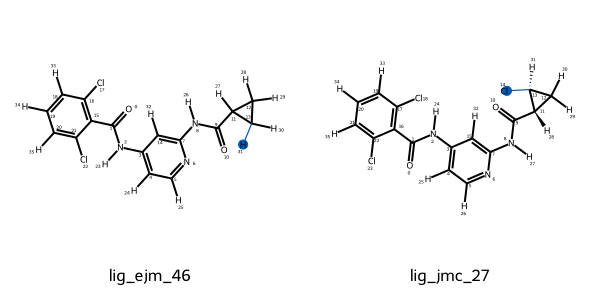

In [42]:
from kartograf import KartografAtomMapper

mapper = KartografAtomMapper()
mapping = next(mapper.suggest_mappings(ligandB_aligned, ligandA))
mapping

Next we define the end state `ChemicalSystem`s

In [47]:
# Complex transformation ChemicalSystems

# state A is the complex with lig_jmc_27
stateA_complex = openfe.ChemicalSystem({
    'ligand': ligandA,
    'protein': protein,
    'solvent': solvent,
})

# state B is the system with lig_ejm_46
stateB_complex = openfe.ChemicalSystem({
    'ligand': ligandB_aligned,
    'protein': protein,
    'solvent': solvent,
})

In [48]:
# Solvent transformation ChemicalSystems

# state A is the complex with lig_jmc_27
stateA_solvent = openfe.ChemicalSystem({
    'ligand': ligandA,
    'solvent': solvent,
})

# state B is the system with lig_ejm_46
stateB_solvent = openfe.ChemicalSystem({
    'ligand': ligandB_aligned,
    'solvent': solvent,
})

Then we create the Protocols for both the solvent and complex phases.

In [46]:
from openfe.protocols.openmm_rfe import RelativeHybridTopologyProtocol
from openff.units import unit

complex_rbfe_settings = RelativeHybridTopologyProtocol.default_settings()
complex_rbfe_settings.protocol_repeats = 1
# we set the solvent padding to 1 nm in the complex to avoid having too many waters
complex_rbfe_settings.solvation_settings.solvent_padding = 1 * unit.nm

complex_rbfe_protocol = RelativeHybridTopologyProtocol(settings=complex_rbfe_settings)

solvent_rbfe_settings = RelativeHybridTopologyProtocol.default_settings()
solvent_rbfe_settings.protocol_repeats = 1
solvent_rbfe_protocol = RelativeHybridTopologyProtocol(settings=solvent_rbfe_settings)

Finally we create the Transformations

In [49]:
transformation_complex = openfe.Transformation(
    stateA=stateA_complex,
    stateB=stateB_complex,
    mapping=mapping,
    protocol=complex_rbfe_protocol,  # use complex protocol created above
    name=f"{ligandA.name}_{ligandB.name}_complex"
)

transformation_solvent = openfe.Transformation(
    stateA=stateA_solvent,
    stateB=stateB_solvent,
    mapping=mapping,
    protocol=solvent_rbfe_protocol,  # use solvent protocol created above
    name=f"{ligandA.name}_{ligandB.name}_solvent"
)

## 7. Creating networks and running the simulations

In practice, one would create entire network of Transformations, and then run all the simulations.
This notebook will not cover these aspects. To find out more about this, please see the [OpenFE Tutorials](https://docs.openfree.energy/en/latest/tutorials/index.html).